In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping

# Image dimensions
img_height, img_width = 256, 256  # You can change this to match your images
batch_size = 32  # Adjust this based on your available memory

# Define the ImageDataGenerator for training, validation, and testing
datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True
)

# Create data generators for training, validation, and test datasets
train_ds = datagen.flow_from_directory(
    'images/train',  # Path to the training data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True  # Shuffle training data
)

val_ds = datagen.flow_from_directory(
    'images/val',  # Path to the validation data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle validation data
)

test_ds = datagen.flow_from_directory(
    'images/test',  # Path to the test data
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Do not shuffle test data
)

# Initialising the CNN model
classifier = Sequential()

# Step 1 - Adding the Convolutional Layer
classifier.add(Conv2D(32, (3, 3), input_shape=(img_height, img_width, 3), activation='relu'))

# Step 2 - Adding MaxPooling Layer
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))

# Step 3 - Flattening the Convolutional Layers' output
classifier.add(Flatten())

# Step 4 - Fully Connected Layers
classifier.add(Dense(units=512, activation='relu'))
classifier.add(BatchNormalization())
classifier.add(Dense(256, activation='relu'))
classifier.add(Dropout(0.25))
classifier.add(Dense(units=2, activation='softmax'))  # Adjust number of units to match your output classes

# Set up the optimizer with a learning rate
optimizer = Adam(learning_rate=0.0001)

# Compile the model
classifier.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Early Stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
model_info = classifier.fit(
    train_ds,
    epochs=150,
    steps_per_epoch=len(train_ds),
    validation_data=val_ds,
    validation_steps=len(val_ds),
    callbacks=[early_stopping]
)

# Access training accuracy from the history object
train_accuracy = model_info.history['accuracy'][-1]  # Last epoch's training accuracy
print(f"Final Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate the model on the test dataset
test_loss, test_accuracy = classifier.evaluate(test_ds)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Found 1032 images belonging to 2 classes.
Found 128 images belonging to 2 classes.
Found 131 images belonging to 2 classes.
Epoch 1/150
33/33 [==============================] - 154s 4s/step - loss: 0.6477 - accuracy: 0.6812 - val_loss: 1.3593 - val_accuracy: 0.5000
Epoch 2/150
33/33 [==============================] - 133s 4s/step - loss: 0.4761 - accuracy: 0.7820 - val_loss: 0.5910 - val_accuracy: 0.6953
Epoch 3/150
33/33 [==============================] - 147s 4s/step - loss: 0.3904 - accuracy: 0.8140 - val_loss: 0.6059 - val_accuracy: 0.6953
Epoch 4/150
33/33 [==============================] - 164s 5s/step - loss: 0.3493 - accuracy: 0.8450 - val_loss: 0.3653 - val_accuracy: 0.8125
Epoch 5/150
33/33 [==============================] - 171s 5s/step - loss: 0.3296 - accuracy: 0.8537 - val_loss: 0.4662 - val_accuracy: 0.7500
Epoch 6/150
33/33 [==============================] - 194s 6s/step - loss: 0.3231 - accuracy: 0.8488 - val_loss: 0.4693 - val_accuracy: 0.7344
Epoch 7/150
33/33 [=====

In [3]:
classifier.save('./best_fit.h5')

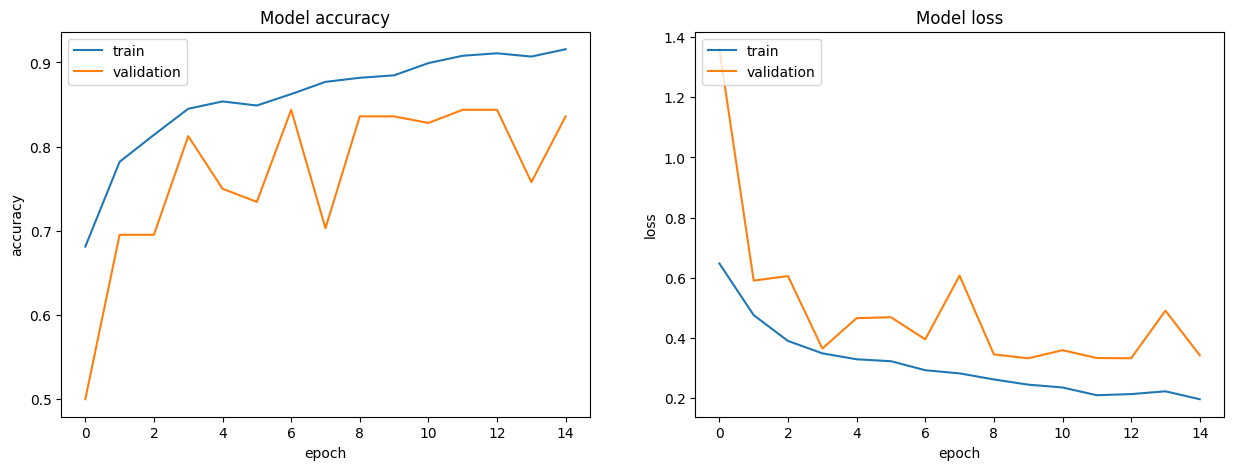

In [5]:
import matplotlib.pyplot as plt  
def plot_train_history(history):
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_train_history(model_info)

In [8]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.models import load_model
model=load_model('./best_fit.h5')
print("Glaucoma detection model loaded")

Glaucoma detection model loaded


In [9]:
def glaucoma_prediction(test_image):
  image = img_to_array(test_image)
  image = np.expand_dims(image, axis = 0)
  result = np.argmax(model.predict(image))
  return result

In [18]:
import numpy as np
test_image = load_img('./ACRIMA/Databases/glucoma/Im320_g_ACRIMA.jpg', target_size = (256,256))
prediction = glaucoma_prediction(test_image)
if prediction == 0:
 print("Glaucoma")
else:
 print("Not Glaucoma")

1/1 [==============================] - 0s 94ms/step
Glaucoma


In [19]:
test_image = load_img('./ACRIMA/Databases/normal/Im002_ACRIMA.jpg', target_size = (256,256))
prediction = glaucoma_prediction(test_image)
if prediction == 0:
 print("Glaucoma")
else:
 print("Not Glaucoma")

1/1 [==============================] - 0s 100ms/step
Not Glaucoma


In [20]:
# Evaluate on validation data
y_true, y_pred = [], []
for images, labels in val_ds:
    y_true.extend(labels)
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))
    if len(y_true) >= val_ds.samples:  # Limit to validation data size
        break

1/1 [==============================] - 0s 288ms/step


In [27]:
from sklearn.metrics import accuracy_score
import numpy as np

# Predict on the test dataset
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

# Get the true labels
y_true = test_ds.classes  # Directly use the integer class labels

# Compute accuracy
test_accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f'Precision: {precision * 100:.2f}')
print(f'Recall: {recall * 100:.2f}')
print(f'F1 Score: {f1 * 100:.2f}')

5/5 [==============================] - 4s 868ms/step
Test Accuracy: 90.08%
Precision: 90.32
Recall: 90.08
F1 Score: 90.06


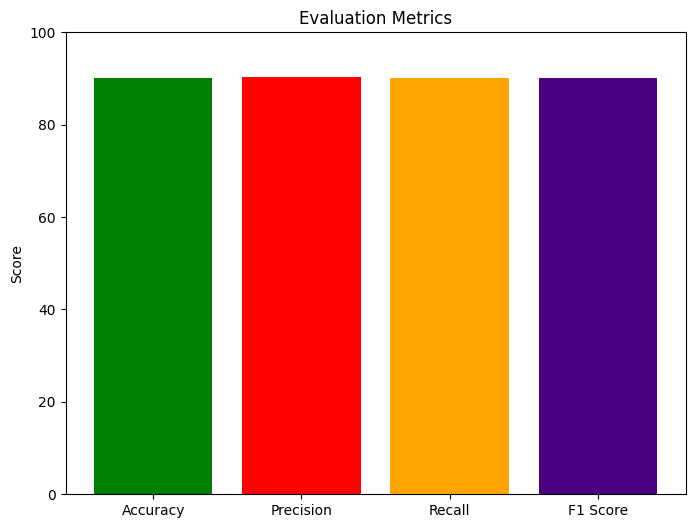

In [33]:
import matplotlib.pyplot as plt

# Evaluation metrics
metrics = {'Accuracy': test_accuracy*100, 'Precision': precision*100, 'Recall': recall*100, 'F1 Score': f1*100}

# Define custom colors for each bar
colors = ['green', 'red', 'orange', 'indigo']  # Choose colors for each metric

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=colors)
plt.title('Evaluation Metrics')
plt.ylabel('Score')
plt.ylim(0, 100)
plt.show()
